In [8]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [9]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
n_images = 10000

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [10]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [11]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [12]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3b175358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt.
INFO:tensorflow:loss = 2.305529, step = 1
INFO:tensorflow:global_step/sec: 2.0698
INFO:tensorflow:loss = 0.2644343, step = 101 (48.315 sec)
INFO:tensorflow:global_step/sec: 2.10065
INFO:tensorflow:loss = 0.13093269, step = 201 (47.604 sec)
INFO:tensorflow:global_step/sec: 2.39225
INFO:tensorflow:loss = 0.117425695, step = 301 (41.802 sec)
INFO:tensorflow:global_step/sec: 2.45479
INFO:tensorflow:loss = 0.12964335, step = 401 (40.736 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0674781.


In [14]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-30-03:03:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-30-03:04:03
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.9673, global_step = 500, loss = 0.118134804
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500


{'accuracy': 0.9673, 'loss': 0.118134804, 'global_step': 500}

In [15]:
write = 1
if write==1:
    f = open("rotate.txt", 'w')

# Predict single images
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.test.labels[:n_images]

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')

X_test_backup = X_test
Y_test_backup = y_test

yBackup = []
pBackup = []

angle = 0.0
accMat = []
for s in range(0,100):
    X_test = X_test_backup
    y_test = Y_test_backup
    angle = angle+0.5
    datagen = ImageDataGenerator(rotation_range=angle)# fit parameters from data
    datagen.fit(X_test)
    tmp = []
    # configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X_test, y_test, batch_size=n_images, shuffle=False):
        tmp = X_batch
        yTemp = y_batch
        break
    y_test = yTemp
    X_test = tmp
    x_te={'images': tmp}
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x=x_te, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    accuracy = 0.0
    # Display
    for i in range(n_images):
        if (preds[i] == y_test[i]):
                accuracy = accuracy + 1/n_images
#         plt.imshow(np.reshape(tmp[i], [28, 28]), cmap='gray')
#         plt.show()
#         print("Model prediction:", preds[i])
    print("Model accuracy:", accuracy)
    yBackup.append(y_test)
    pBackup.append(preds)
    accMat.append(accuracy)
    if write==1:
        f.write(str(angle)+"\t"+str(accuracy)+"\n")
if write==1:
    f.close()
print("Done!")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9668999999999098
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9663999999999099
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_o

INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9533999999999113
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9546999999999112
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9511999999999116
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
I

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9120999999999159
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9113999999999159
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.910599999999916
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6j

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.837799999999924
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.8359999999999242
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.8343999999999244
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6j

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7372999999999351
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.747499999999934
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpi_rhh72q/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7363999999999352
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6j

In [25]:
yTotal = [0]*10

for y in y_test:
    yTotal[y] = yTotal[y]+1

aMatrix = []
for i in range(len(pBackup)):
    print("\n\nYmatrix for rotation %d"%(i))
    yMatrix = [[0]*10 for i in range(10)]
    for j in range(len(pBackup[i])):
        yMatrix[yBackup[i][j]][pBackup[i][j]] += 1

    sum = 0
    
    for x in range(len(yMatrix)):
        for y in range(len(yMatrix[x])):
            yMatrix[x][y] = round(yMatrix[x][y]/yTotal[x], 3)

    aMatrix.append(yMatrix)
    for x in yMatrix:
        for y in x:
            print("%f" % (y),end=" ")
        print()
    



Ymatrix for rotation 0
0.995000 0.001000 0.000000 0.000000 0.000000 0.002000 0.000000 0.000000 0.002000 0.000000 
0.000000 0.981000 0.000000 0.004000 0.001000 0.000000 0.001000 0.000000 0.013000 0.000000 
0.006000 0.005000 0.926000 0.020000 0.003000 0.000000 0.001000 0.016000 0.022000 0.000000 
0.001000 0.000000 0.001000 0.967000 0.000000 0.016000 0.000000 0.007000 0.008000 0.000000 
0.002000 0.000000 0.000000 0.000000 0.989000 0.000000 0.002000 0.000000 0.002000 0.005000 
0.002000 0.002000 0.000000 0.003000 0.001000 0.983000 0.003000 0.001000 0.002000 0.001000 
0.024000 0.004000 0.000000 0.000000 0.003000 0.004000 0.962000 0.000000 0.002000 0.000000 
0.001000 0.007000 0.004000 0.004000 0.004000 0.000000 0.000000 0.969000 0.011000 0.001000 
0.008000 0.002000 0.001000 0.001000 0.004000 0.007000 0.001000 0.004000 0.966000 0.005000 
0.007000 0.006000 0.000000 0.002000 0.013000 0.007000 0.000000 0.014000 0.020000 0.932000 


Ymatrix for rotation 1
0.995000 0.001000 0.000000 0.000000 0.00

0.004000 0.003000 0.000000 0.007000 0.003000 0.971000 0.008000 0.000000 0.003000 0.000000 
0.029000 0.004000 0.000000 0.000000 0.002000 0.005000 0.956000 0.000000 0.003000 0.000000 
0.002000 0.011000 0.004000 0.006000 0.004000 0.000000 0.000000 0.958000 0.012000 0.004000 
0.007000 0.001000 0.000000 0.000000 0.005000 0.005000 0.005000 0.004000 0.967000 0.005000 
0.010000 0.008000 0.000000 0.001000 0.015000 0.005000 0.000000 0.016000 0.022000 0.924000 


Ymatrix for rotation 15
0.995000 0.001000 0.000000 0.000000 0.000000 0.002000 0.000000 0.000000 0.002000 0.000000 
0.001000 0.980000 0.000000 0.004000 0.000000 0.000000 0.002000 0.000000 0.013000 0.000000 
0.016000 0.011000 0.885000 0.022000 0.004000 0.000000 0.002000 0.022000 0.037000 0.001000 
0.001000 0.000000 0.001000 0.961000 0.000000 0.020000 0.000000 0.007000 0.010000 0.000000 
0.002000 0.001000 0.000000 0.000000 0.987000 0.000000 0.001000 0.000000 0.006000 0.003000 
0.003000 0.001000 0.000000 0.007000 0.002000 0.974000 0.006000 0

0.995000 0.000000 0.000000 0.000000 0.002000 0.002000 0.000000 0.000000 0.001000 0.000000 
0.000000 0.984000 0.000000 0.004000 0.001000 0.001000 0.001000 0.000000 0.010000 0.000000 
0.013000 0.016000 0.871000 0.019000 0.006000 0.000000 0.001000 0.035000 0.038000 0.001000 
0.001000 0.000000 0.001000 0.962000 0.000000 0.022000 0.000000 0.006000 0.008000 0.000000 
0.004000 0.002000 0.003000 0.000000 0.978000 0.000000 0.001000 0.000000 0.009000 0.003000 
0.006000 0.002000 0.000000 0.010000 0.003000 0.957000 0.011000 0.000000 0.008000 0.002000 
0.029000 0.003000 0.000000 0.000000 0.004000 0.005000 0.952000 0.000000 0.006000 0.000000 
0.004000 0.013000 0.007000 0.003000 0.009000 0.000000 0.000000 0.943000 0.018000 0.004000 
0.008000 0.002000 0.000000 0.002000 0.007000 0.006000 0.005000 0.001000 0.960000 0.008000 
0.015000 0.009000 0.000000 0.002000 0.019000 0.003000 0.000000 0.015000 0.029000 0.909000 


Ymatrix for rotation 28
0.992000 0.002000 0.000000 0.000000 0.001000 0.003000 0.000000 0

0.993000 0.000000 0.000000 0.000000 0.003000 0.001000 0.001000 0.000000 0.002000 0.000000 
0.002000 0.972000 0.000000 0.003000 0.005000 0.004000 0.001000 0.000000 0.013000 0.000000 
0.013000 0.024000 0.835000 0.025000 0.008000 0.000000 0.000000 0.039000 0.053000 0.003000 
0.003000 0.000000 0.001000 0.954000 0.001000 0.024000 0.000000 0.003000 0.013000 0.001000 
0.006000 0.003000 0.003000 0.000000 0.961000 0.000000 0.000000 0.000000 0.023000 0.003000 
0.009000 0.002000 0.000000 0.016000 0.004000 0.939000 0.009000 0.000000 0.020000 0.000000 
0.033000 0.004000 0.000000 0.000000 0.005000 0.007000 0.946000 0.000000 0.004000 0.000000 
0.009000 0.017000 0.009000 0.004000 0.012000 0.002000 0.000000 0.921000 0.019000 0.008000 
0.017000 0.004000 0.000000 0.000000 0.012000 0.004000 0.005000 0.004000 0.947000 0.006000 
0.014000 0.009000 0.000000 0.001000 0.028000 0.009000 0.000000 0.018000 0.045000 0.877000 


Ymatrix for rotation 39
0.993000 0.001000 0.000000 0.000000 0.001000 0.003000 0.000000 0

0.009000 0.002000 0.000000 0.020000 0.009000 0.923000 0.021000 0.000000 0.015000 0.001000 
0.043000 0.004000 0.000000 0.000000 0.005000 0.013000 0.931000 0.000000 0.004000 0.000000 
0.009000 0.022000 0.015000 0.005000 0.012000 0.002000 0.000000 0.897000 0.033000 0.006000 
0.018000 0.002000 0.001000 0.001000 0.024000 0.007000 0.018000 0.003000 0.915000 0.010000 
0.016000 0.008000 0.001000 0.002000 0.023000 0.008000 0.000000 0.019000 0.072000 0.851000 


Ymatrix for rotation 48
0.994000 0.000000 0.000000 0.000000 0.000000 0.001000 0.002000 0.001000 0.002000 0.000000 
0.001000 0.956000 0.001000 0.004000 0.010000 0.010000 0.000000 0.000000 0.019000 0.000000 
0.018000 0.041000 0.750000 0.041000 0.011000 0.000000 0.000000 0.059000 0.078000 0.002000 
0.004000 0.000000 0.001000 0.948000 0.001000 0.024000 0.000000 0.008000 0.015000 0.000000 
0.005000 0.002000 0.002000 0.000000 0.939000 0.000000 0.004000 0.002000 0.039000 0.007000 
0.007000 0.004000 0.000000 0.020000 0.008000 0.917000 0.022000 0

0.054000 0.006000 0.000000 0.000000 0.013000 0.019000 0.903000 0.001000 0.004000 0.000000 
0.010000 0.021000 0.041000 0.005000 0.032000 0.003000 0.000000 0.827000 0.040000 0.021000 
0.027000 0.003000 0.003000 0.003000 0.021000 0.010000 0.013000 0.001000 0.914000 0.005000 
0.016000 0.007000 0.001000 0.002000 0.030000 0.013000 0.002000 0.017000 0.092000 0.821000 


Ymatrix for rotation 62
0.989000 0.001000 0.000000 0.002000 0.002000 0.003000 0.000000 0.002000 0.000000 0.001000 
0.000000 0.914000 0.000000 0.003000 0.027000 0.015000 0.002000 0.001000 0.039000 0.000000 
0.035000 0.041000 0.707000 0.029000 0.017000 0.000000 0.000000 0.077000 0.092000 0.002000 
0.008000 0.000000 0.002000 0.914000 0.002000 0.030000 0.000000 0.004000 0.040000 0.001000 
0.011000 0.004000 0.009000 0.004000 0.871000 0.002000 0.005000 0.004000 0.081000 0.008000 
0.017000 0.003000 0.000000 0.026000 0.009000 0.882000 0.022000 0.000000 0.033000 0.008000 
0.049000 0.001000 0.000000 0.000000 0.010000 0.021000 0.911000 0

0.987000 0.001000 0.001000 0.001000 0.001000 0.007000 0.000000 0.000000 0.002000 0.000000 
0.000000 0.897000 0.000000 0.004000 0.033000 0.016000 0.003000 0.001000 0.047000 0.000000 
0.031000 0.040000 0.644000 0.049000 0.024000 0.002000 0.004000 0.092000 0.112000 0.001000 
0.016000 0.000000 0.002000 0.889000 0.003000 0.054000 0.000000 0.004000 0.031000 0.001000 
0.010000 0.011000 0.017000 0.003000 0.840000 0.004000 0.006000 0.007000 0.090000 0.011000 
0.028000 0.002000 0.000000 0.025000 0.010000 0.842000 0.049000 0.001000 0.034000 0.009000 
0.066000 0.002000 0.000000 0.002000 0.014000 0.024000 0.881000 0.001000 0.010000 0.000000 
0.029000 0.028000 0.056000 0.008000 0.035000 0.005000 0.002000 0.755000 0.055000 0.026000 
0.039000 0.001000 0.001000 0.007000 0.031000 0.009000 0.020000 0.002000 0.878000 0.012000 
0.033000 0.007000 0.000000 0.003000 0.031000 0.018000 0.004000 0.017000 0.116000 0.772000 


Ymatrix for rotation 72
0.989000 0.000000 0.000000 0.001000 0.001000 0.005000 0.002000 0

0.985000 0.002000 0.000000 0.001000 0.001000 0.006000 0.000000 0.002000 0.002000 0.001000 
0.000000 0.812000 0.000000 0.003000 0.057000 0.040000 0.003000 0.000000 0.085000 0.001000 
0.047000 0.050000 0.574000 0.050000 0.047000 0.000000 0.003000 0.101000 0.122000 0.006000 
0.020000 0.002000 0.002000 0.843000 0.004000 0.059000 0.004000 0.005000 0.053000 0.008000 
0.012000 0.014000 0.016000 0.010000 0.752000 0.010000 0.008000 0.010000 0.155000 0.012000 
0.050000 0.001000 0.000000 0.026000 0.015000 0.777000 0.080000 0.001000 0.034000 0.017000 
0.079000 0.004000 0.000000 0.000000 0.017000 0.057000 0.833000 0.001000 0.007000 0.001000 
0.018000 0.042000 0.116000 0.004000 0.070000 0.002000 0.008000 0.641000 0.064000 0.035000 
0.066000 0.001000 0.001000 0.004000 0.042000 0.016000 0.025000 0.003000 0.831000 0.011000 
0.042000 0.005000 0.001000 0.002000 0.037000 0.040000 0.012000 0.010000 0.143000 0.710000 


Ymatrix for rotation 89
0.987000 0.001000 0.000000 0.001000 0.001000 0.007000 0.001000 0

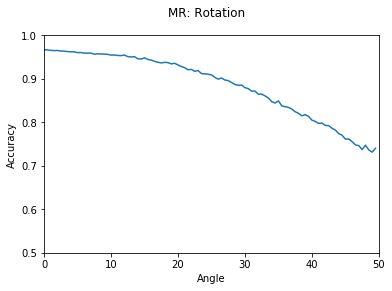

In [38]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.axis([0, 50, 0.5, 1])
plt.plot(np.arange(0,50,0.5),accMat)
plt.xlabel("Angle")
plt.ylabel("Accuracy")
plt.suptitle("MR: Rotation")
plt.show()

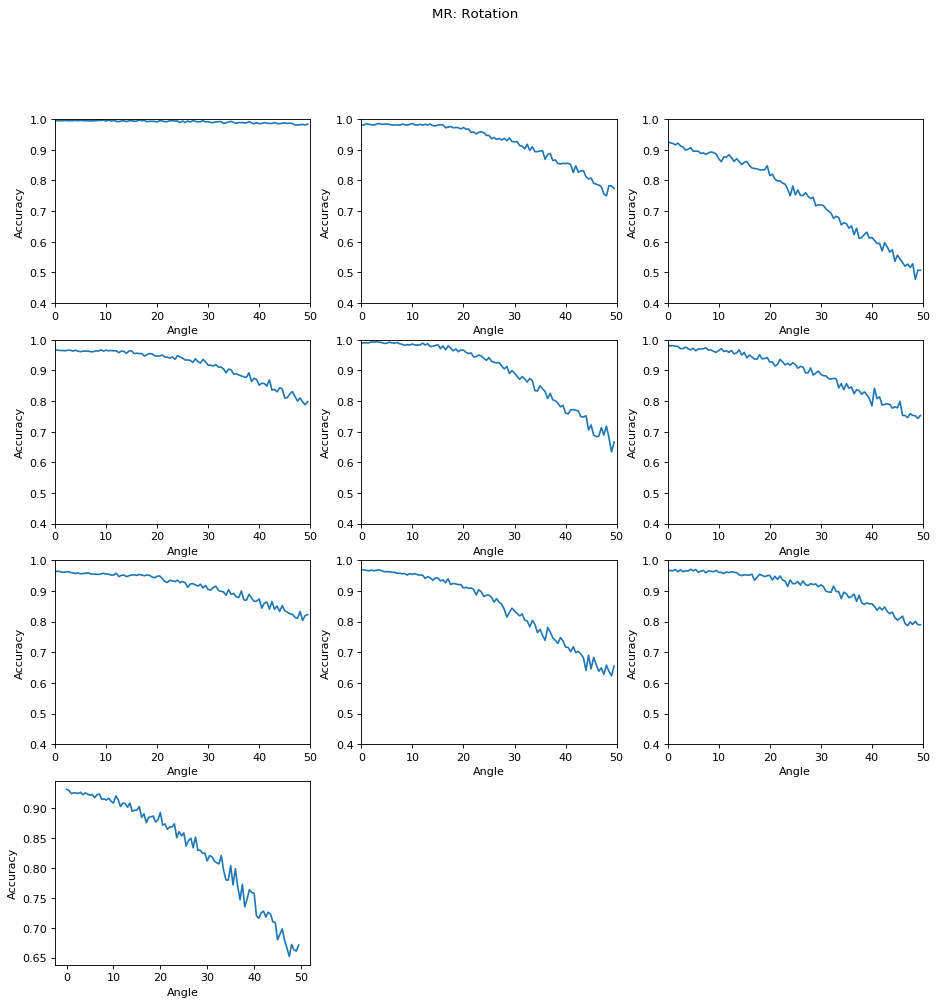

In [39]:
figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

zero = []
for j in range(10):
    zero = []
    for i in range(len(aMatrix)):
        zero.append(aMatrix[i][j][j])    
    plt.axis([0, 50, 0.4, 1])
    plt.subplot(4,3,j+1)
    plt.plot(np.arange(0,50,0.5),zero)
    plt.xlabel("Angle")
    plt.ylabel("Accuracy")
    
plt.suptitle("MR: Rotation")
plt.show()

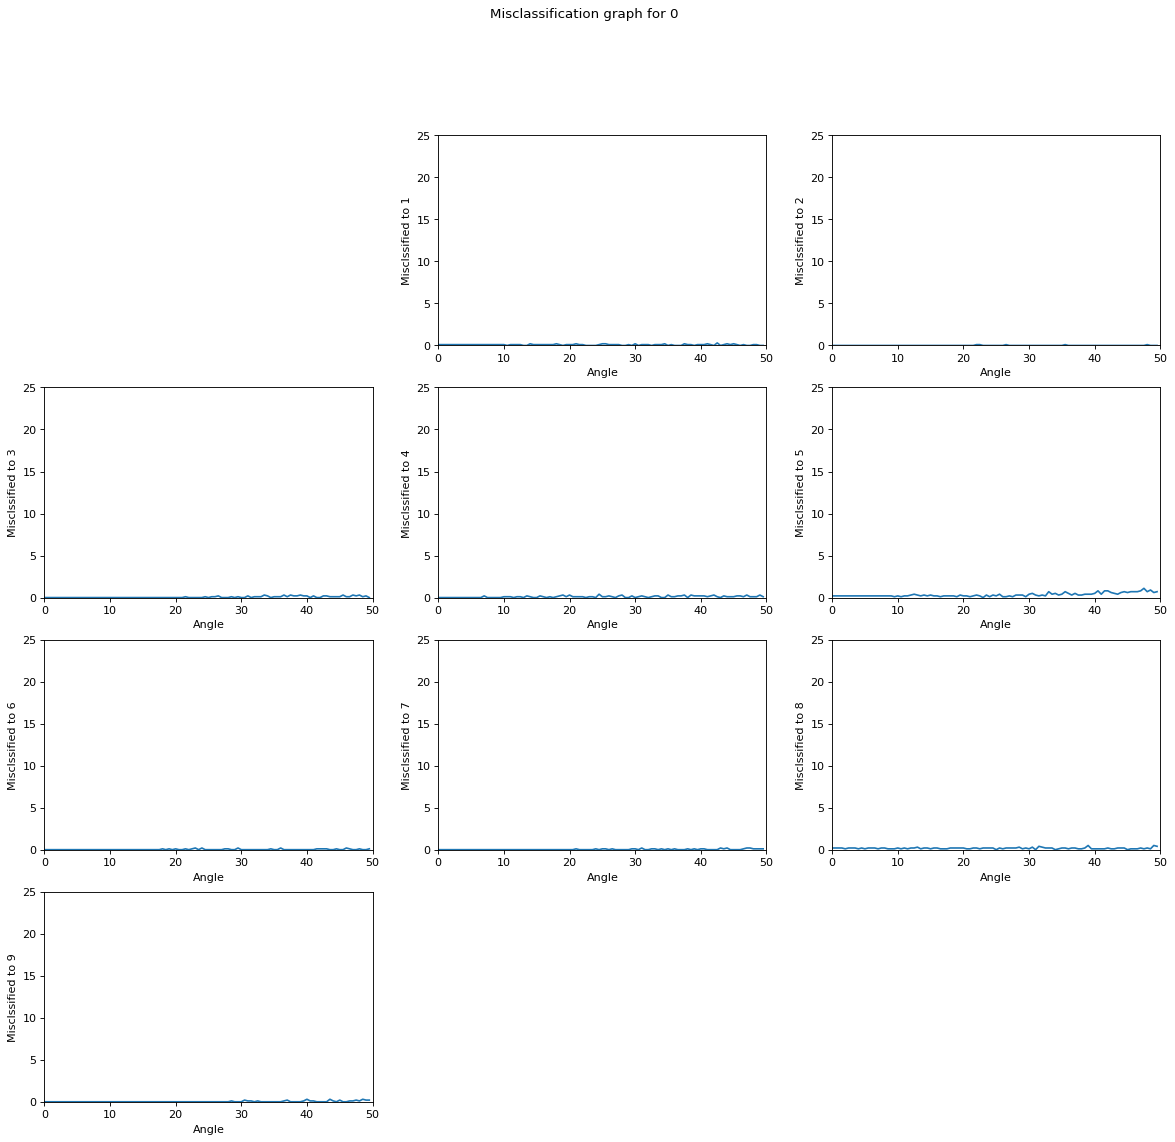

---------------------------------------------------------------------------------------------------------------------


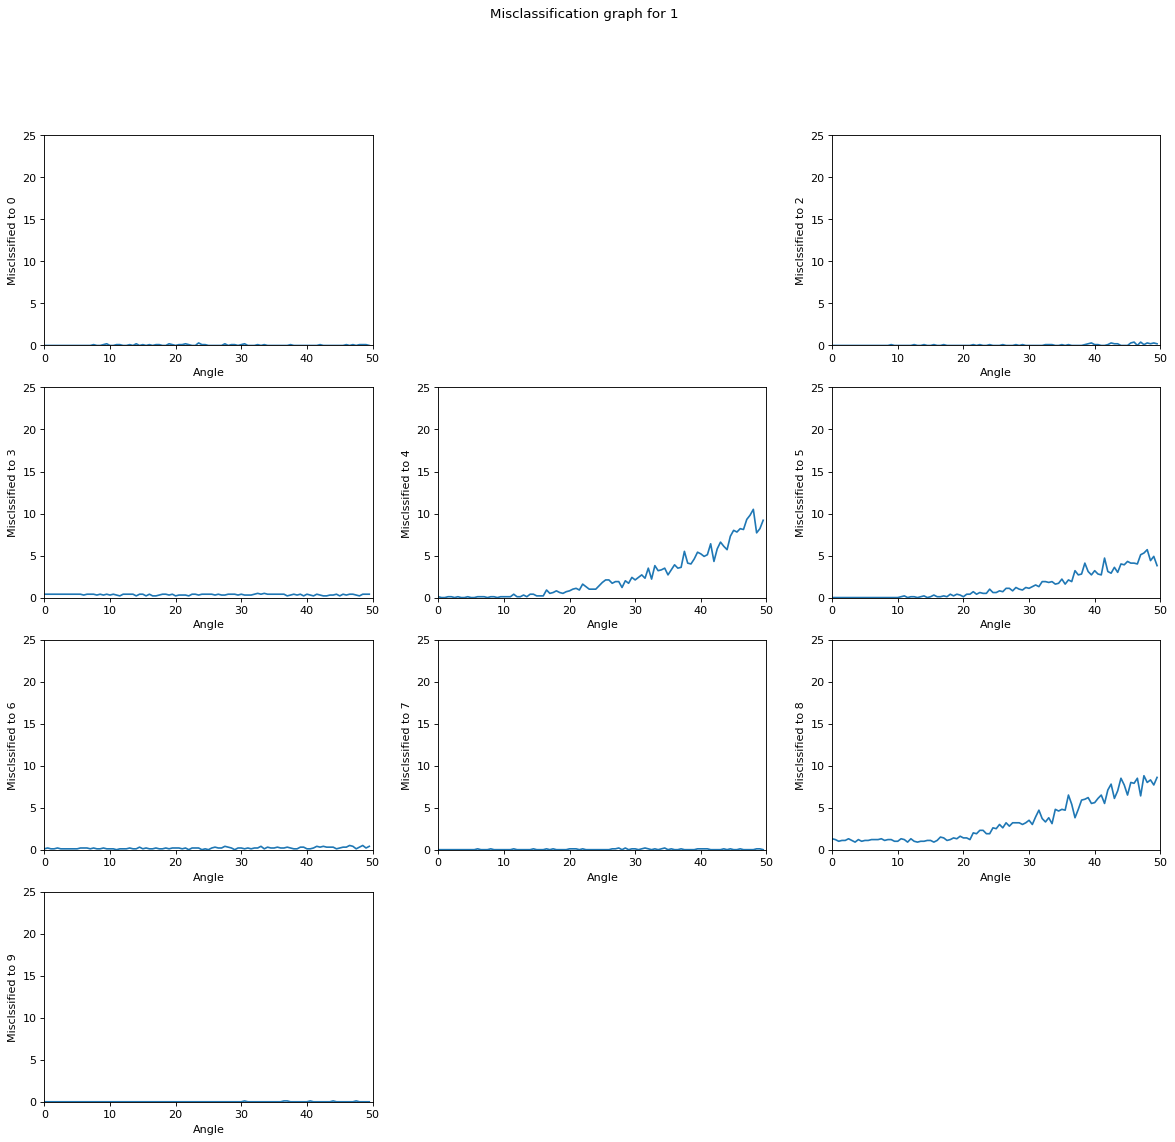

---------------------------------------------------------------------------------------------------------------------


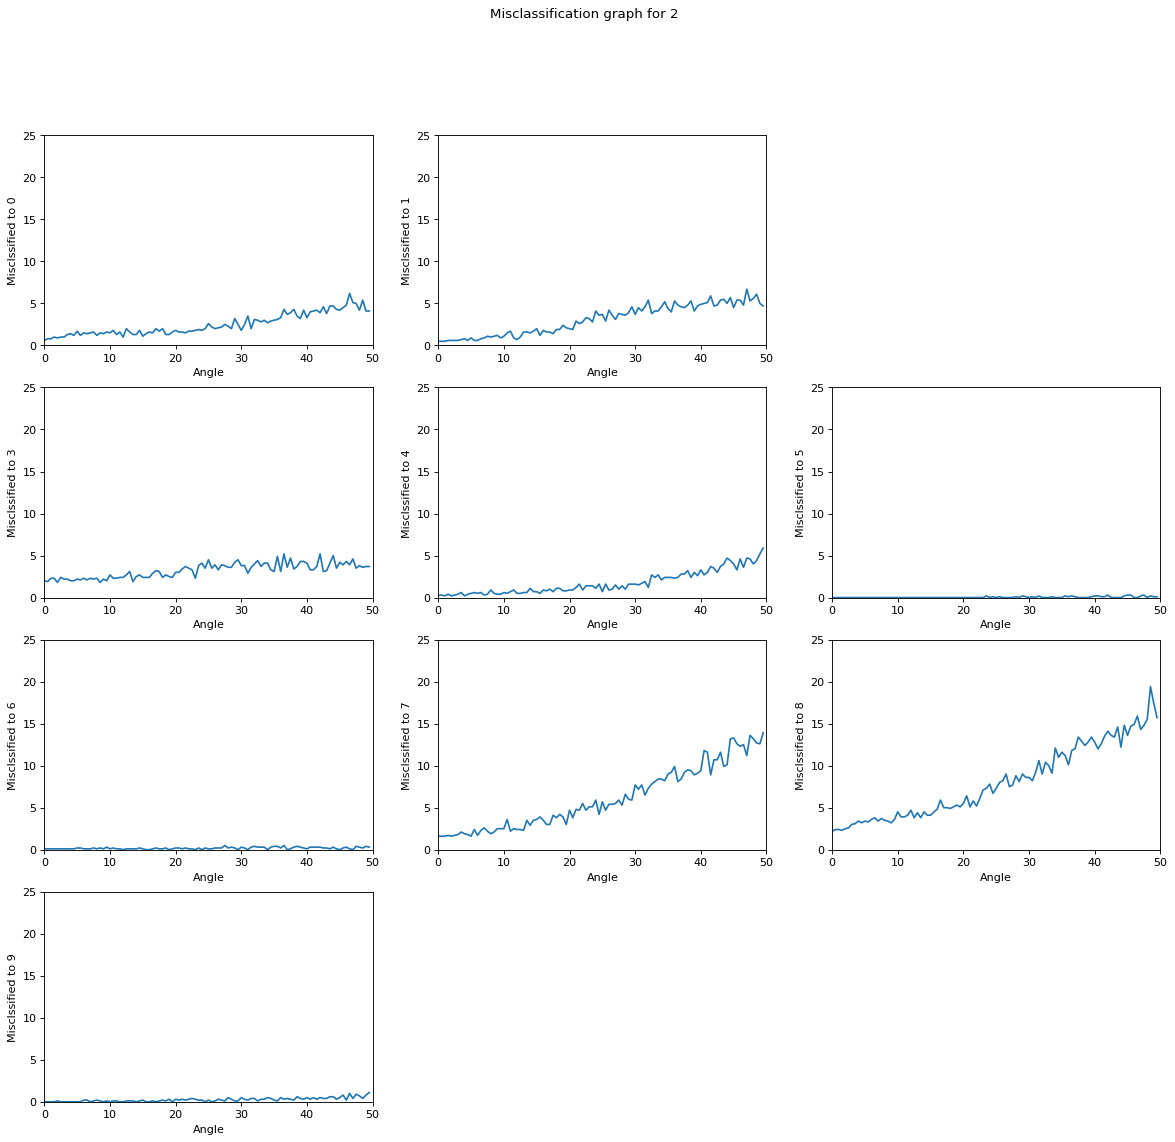

---------------------------------------------------------------------------------------------------------------------


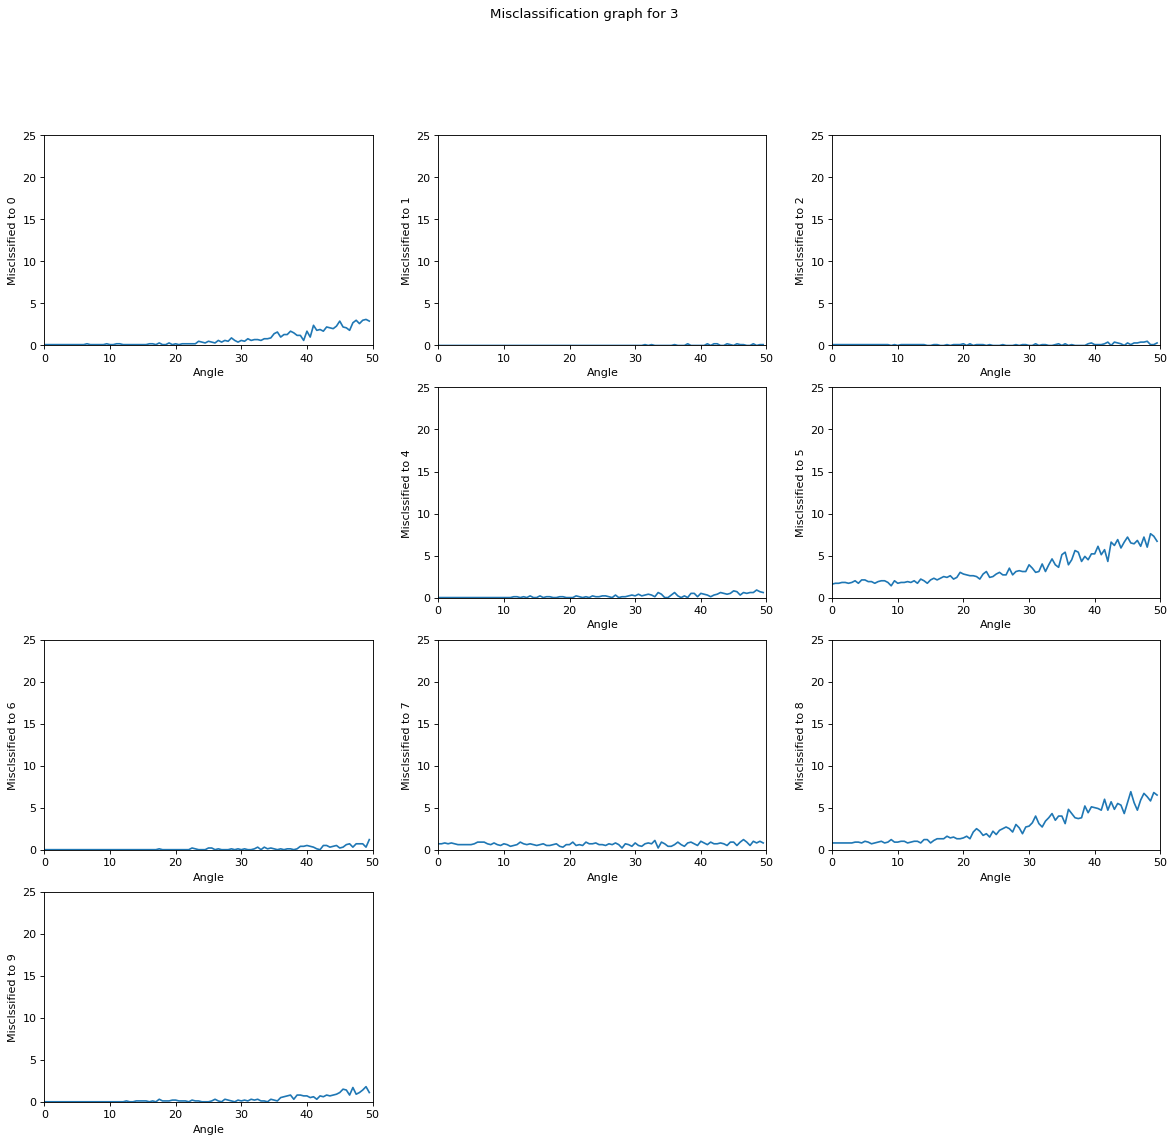

---------------------------------------------------------------------------------------------------------------------


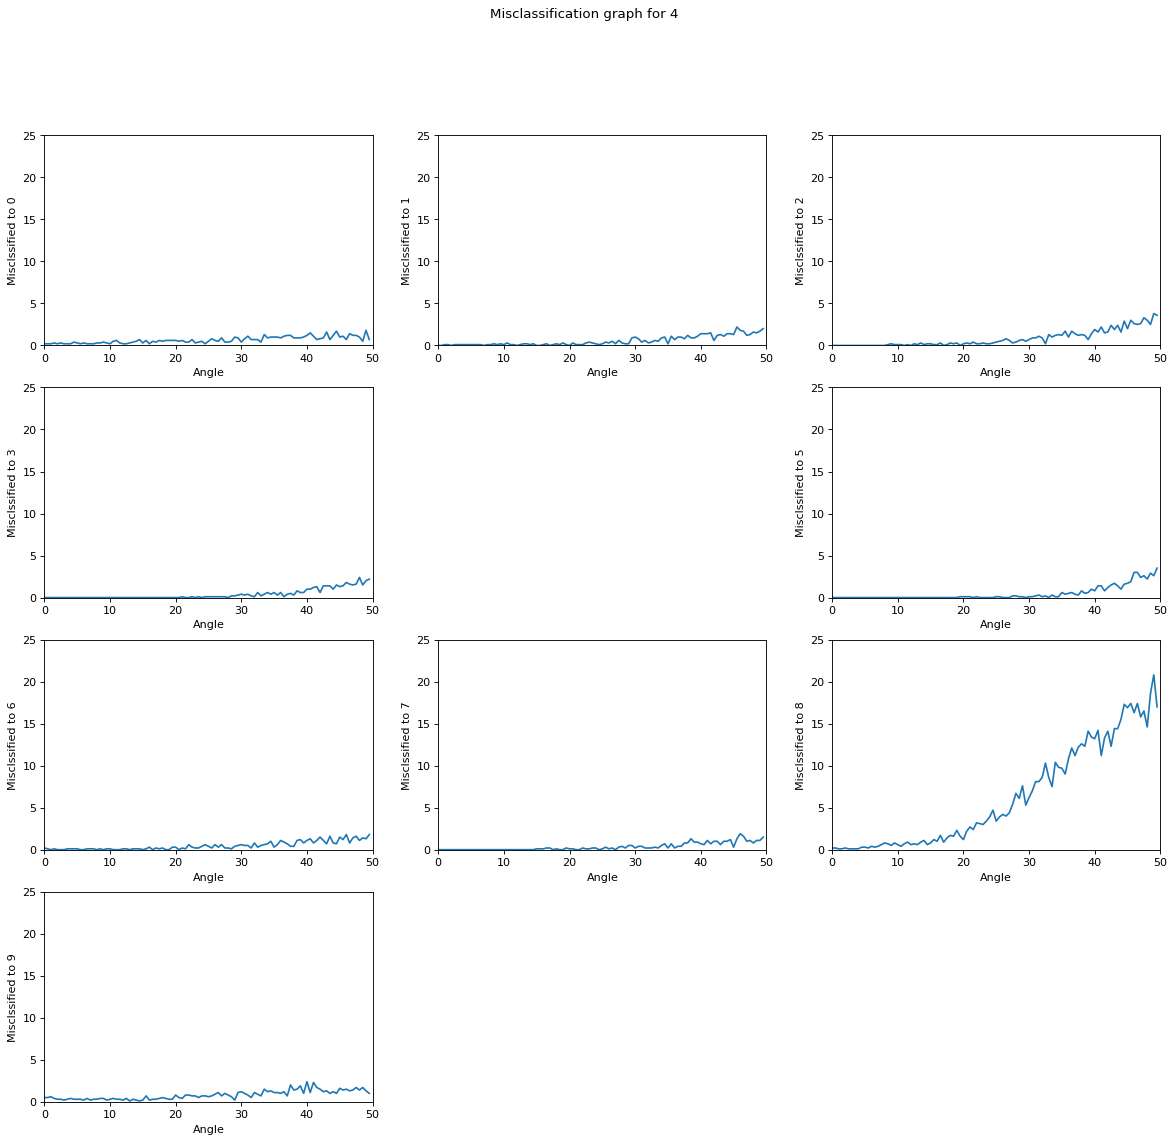

---------------------------------------------------------------------------------------------------------------------


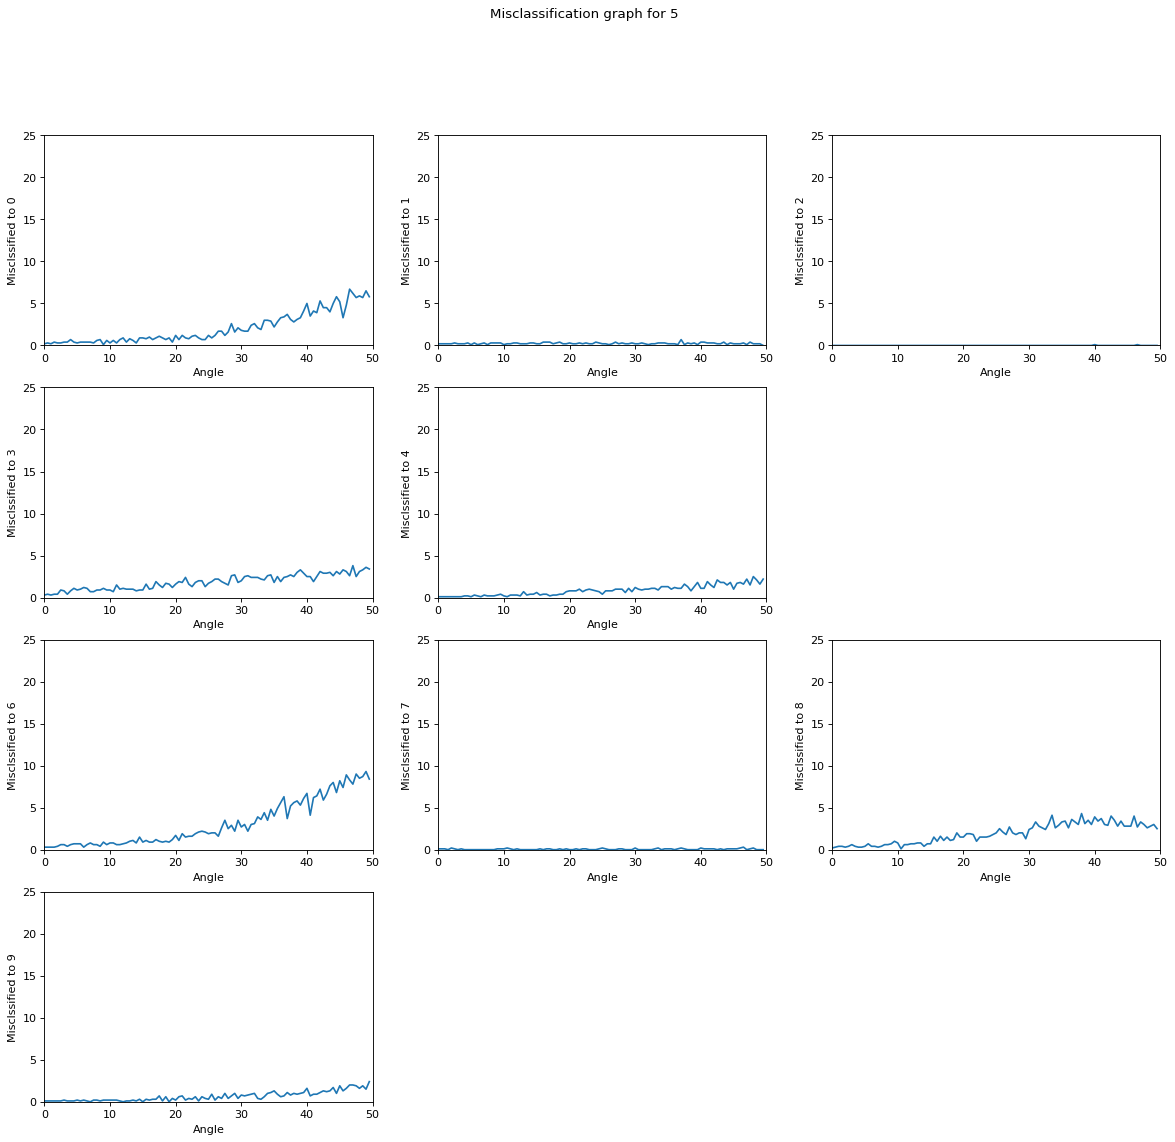

---------------------------------------------------------------------------------------------------------------------


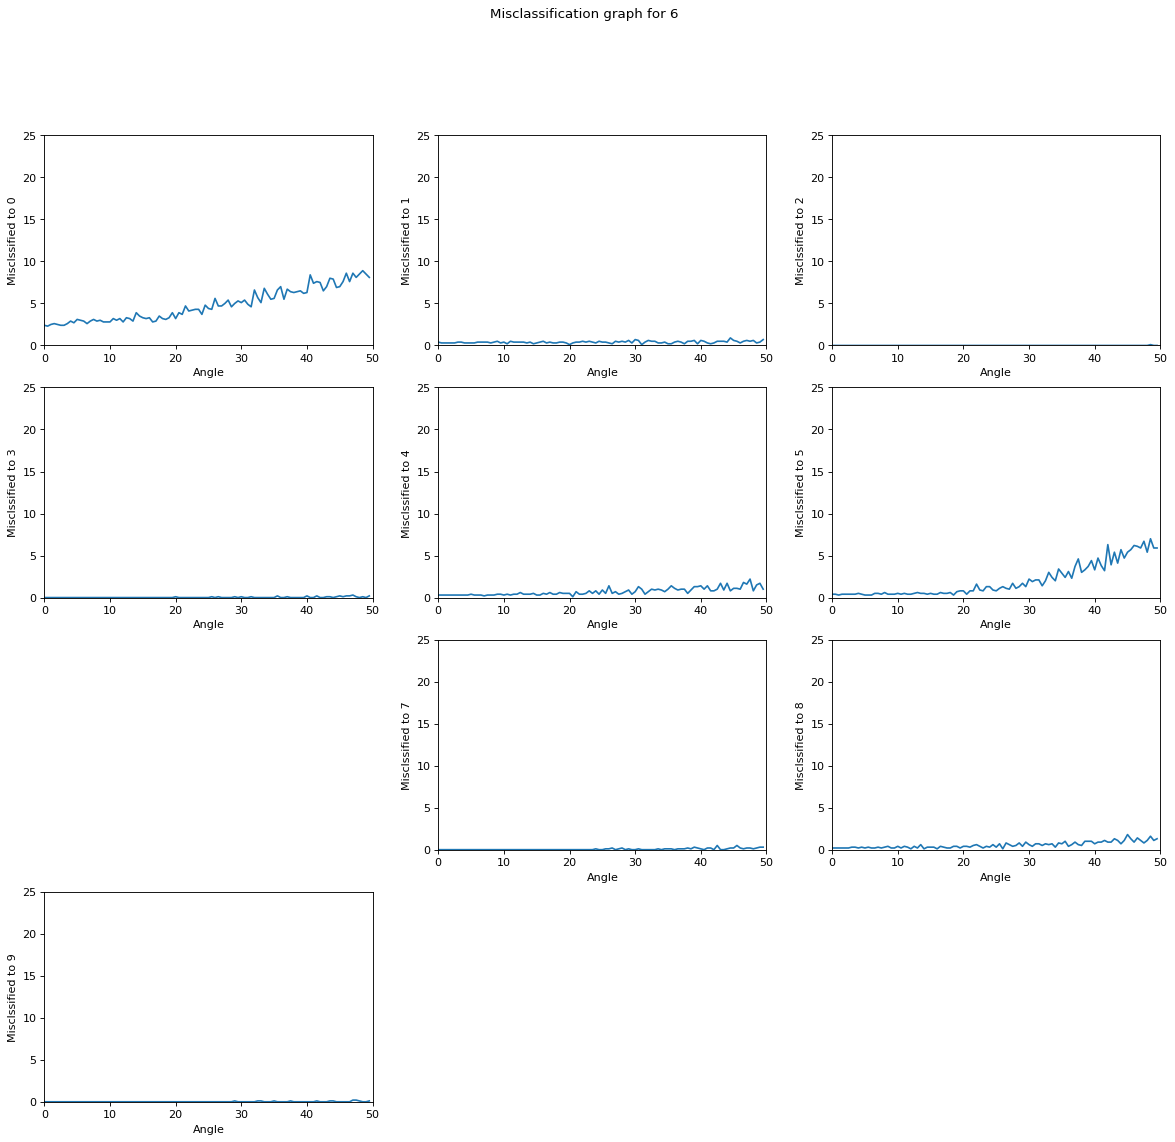

---------------------------------------------------------------------------------------------------------------------


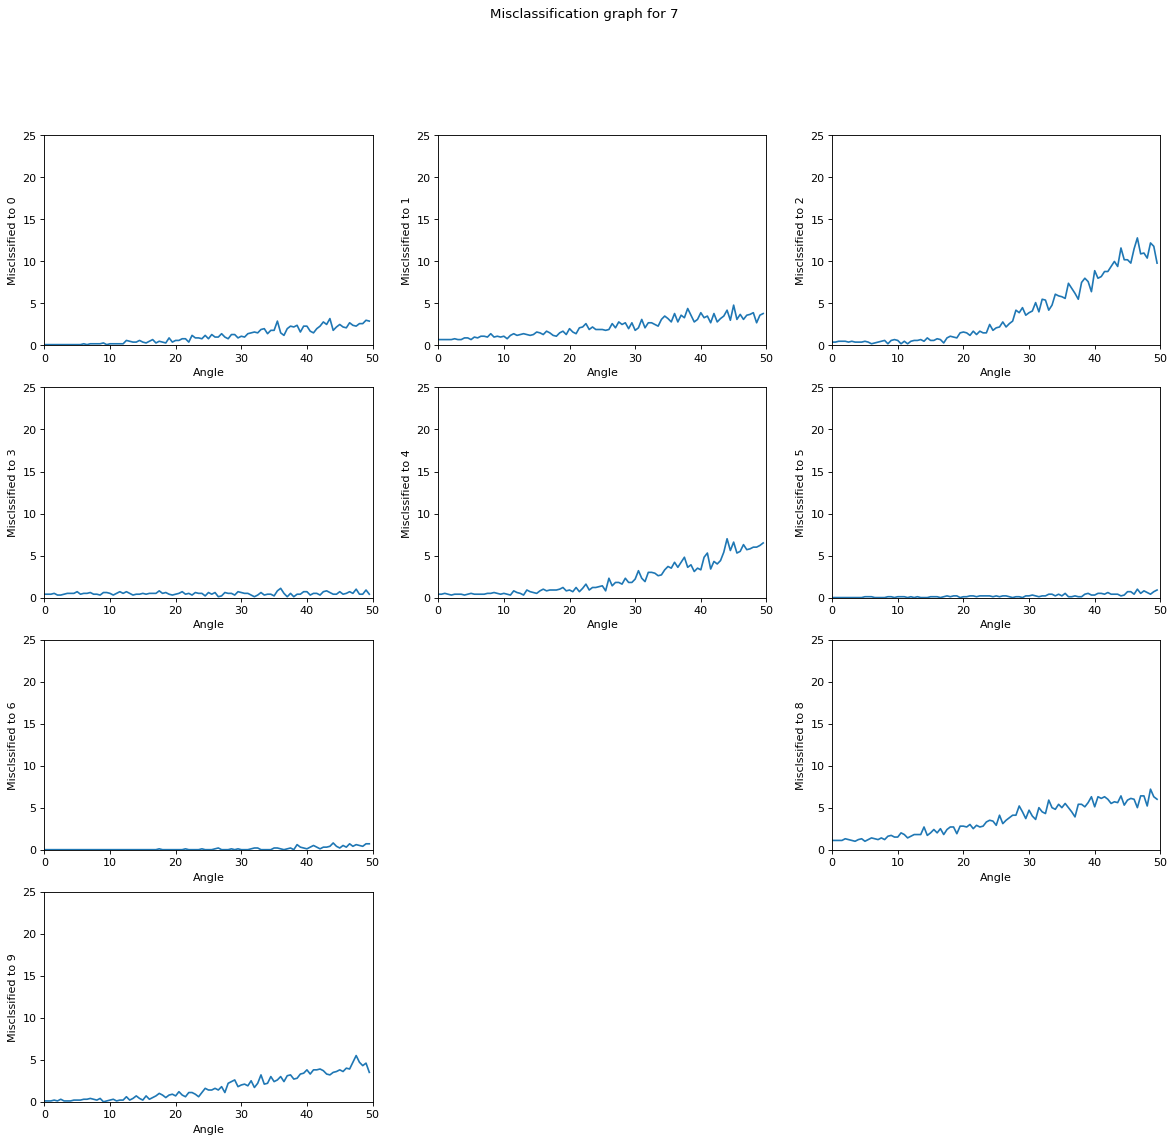

---------------------------------------------------------------------------------------------------------------------


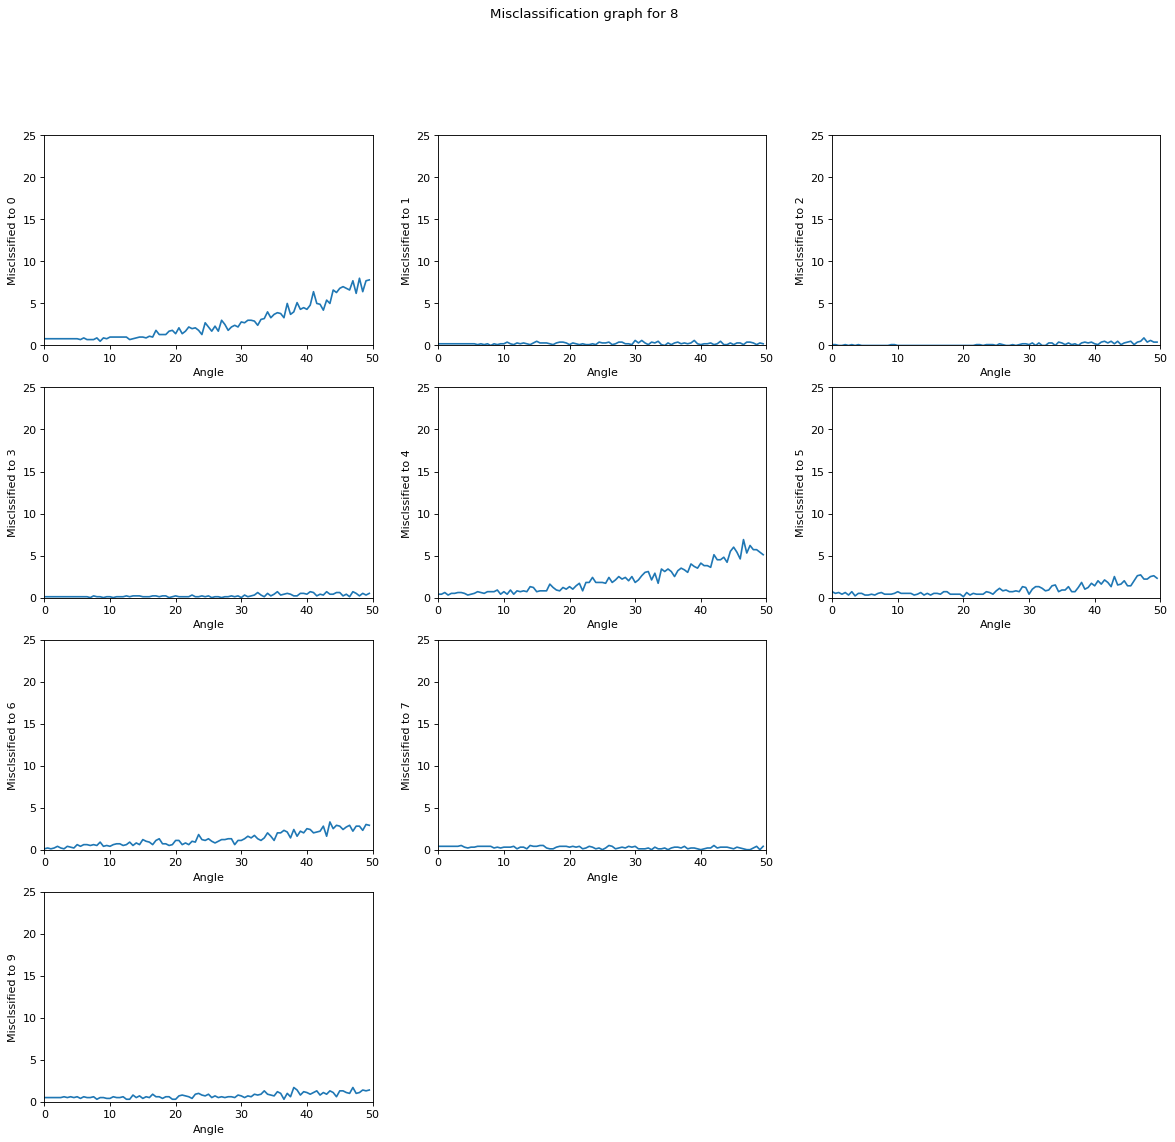

---------------------------------------------------------------------------------------------------------------------


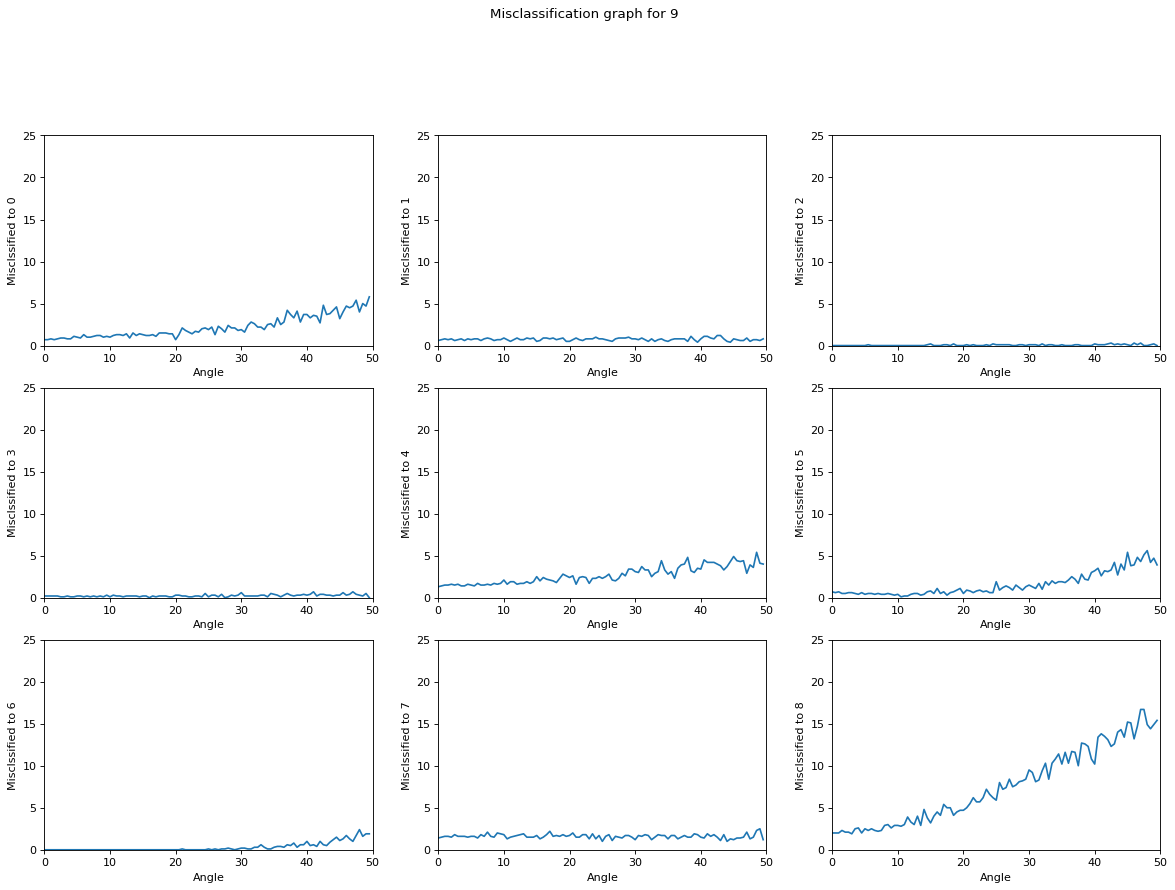

---------------------------------------------------------------------------------------------------------------------


In [40]:
zero = []

for j in range(10):
    figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    for k in range(0,10):
        zero = []
        if j != k: 
            for i in range(len(aMatrix)):
                zero.append(aMatrix[i][j][k]*100)
        else:
            continue
        plt.subplot(4,3,k+1)
        plt.axis([0, 50, 0,25])
        plt.plot(np.arange(0,50,0.5),zero)
        plt.xlabel("Angle")
        plt.ylabel("Misclssified to %s" %str(k))
    plt.suptitle("Misclassification graph for %d" %(j))
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------")